# Air India Customer Reviews Sentiment Analysis

- We are going to perform sentiment analysis on the customer reviews of Air India. 

- The data is sourced from [Skytrax](https://www.airlinequality.com/) website.

## Code Flow

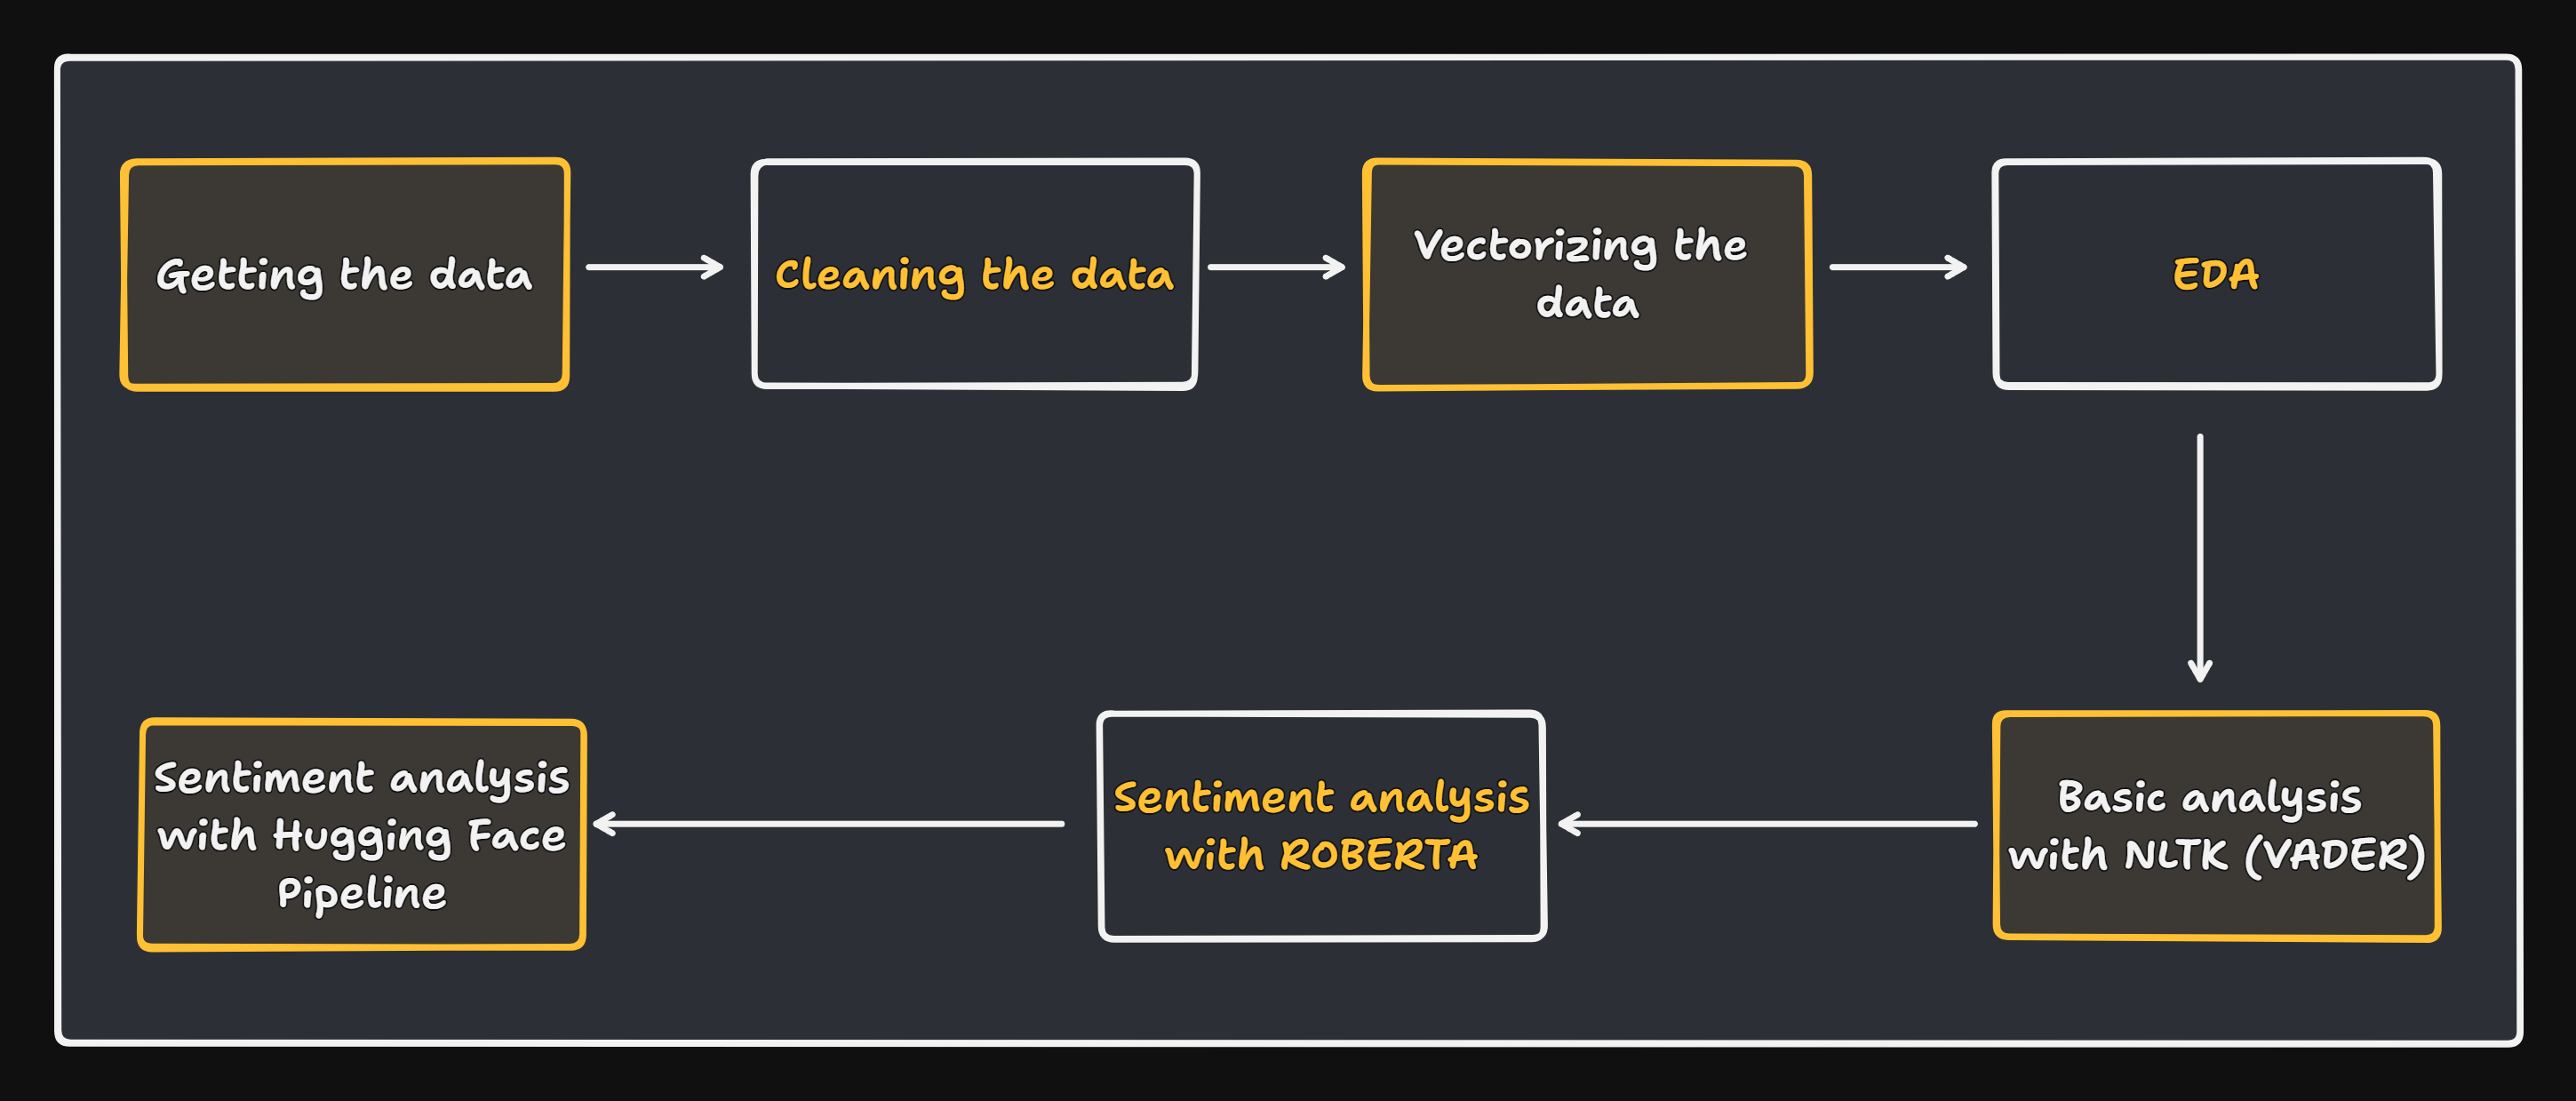

## 0. Getting Data

**This is for educational purpose only**; 

All the data collected from **[Skytrax](https://www.airlinequality.com/)** is the intellectual properties of `Skytrax` and is collected by abiding with their terms and conditions. Please read their terms and conditions before performing any sort of automated actions on their site or servers.

In [1]:
import numpy as np
import pandas as pd

In [1]:
# libs for scraping
import os
import requests
import concurrent.futures
from bs4 import BeautifulSoup

In [ ]:
# Function to fetch reviews from a single page
def fetch_page_reviews(base_url, page, page_size):
    try:
        print(f"Scraping page {page}")

        # URL from paginated data
        url = f"{base_url}/page/{page}/?sortby=post_date%3ADesc&pagesize={page_size}"

        # Collect HTML data from this page
        res = requests.get(url)
        res.raise_for_status()  # Ensuring request was successful

        # Parsing content
        parsed_content = BeautifulSoup(res.content, 'html.parser')

        # Extract review text and rating from current page
        page_reviews = parsed_content.find_all("div", class_="text_content")
        page_ratings = parsed_content.find_all("div", class_="rating-10")

        reviews_with_ratings = []
        for review, rating in zip(page_reviews, page_ratings):
            review_text = review.get_text(strip=True)
            if rating.find("span", itemprop="ratingValue") is None:
                rating_value = np.nan
            else:
                rating_value = rating.find("span", itemprop="ratingValue").get_text(strip=True)
            reviews_with_ratings.append({"Review": review_text, "Rating": rating_value})

        return reviews_with_ratings

    except requests.exceptions.RequestException as e:
        print(f"Failed to scrape page {page}: {e}")
        return []


# Function to fetch reviews from multiple pages concurrently
def get_data(base_url, pages, page_size):
    """Concurrently fetches reviews from multiple pages.

    Args: 
    base_url (str): The URL of the reviews page.
    pages (int): The number of pages to scrape.
    page_size (int): The number of reviews per page.

    Returns:
    list: A list of dictionaries containing the reviews and ratings.
    """

    # To store the reviews
    reviews = []
    try: 
        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = [executor.submit(fetch_page_reviews, base_url, page, page_size) for page in range(1, pages + 1)]
            for future in concurrent.futures.as_completed(futures):
                reviews.extend(future.result())

        print(f"Scraping completed; Collected {len(reviews)} reviews.")
    except Exception as e:
        print(f'Exception {e} occurred')
    return reviews


# Function to save data to a CSV file
def save_data_csv(data, file_path="./Data/Air_India_reviews.csv"):
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    df_reviews = pd.DataFrame(data)
    df_reviews.to_csv(file_path, index=False, encoding='utf-8')
    print(f"Data saved to {file_path}")


In [ ]:
# Run this cell only once to scrape the data.

# Define base URL and scraping parameters
base_url = "https://www.airlinequality.com/airline-reviews/air-india/"
pages = 14
page_size = 100

reviews = get_data(base_url, pages, page_size)

csv_file_path = "./Data/Air_India_reviews.csv"
if reviews:
    save_data_csv(reviews, csv_file_path)
else:
    print('Unable to collect reviews')

- The site contains much more information than just reviews, like ratings, individual rating on different aspects of the flight, etc. Here I am collecting ratings and reviews only.

## 1. Loading data

In [2]:
df = pd.read_csv('./Data/Air_India_reviews.csv')

## 2. Understanding the data

In [3]:
df.head()

,Review,Rating
0,Not Verified| Flight was okay to travel as we...,4.0
1,✅Trip Verified| After avoiding Air India for ...,5.0
2,✅Trip Verified| Horrible experience with cust...,4.0
3,✅Trip Verified| I had decided to use my miles...,2.0
4,✅Trip Verified| The Ticketing staff at Delhi ...,9.0


In [4]:
df.shape

(1346, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1346 entries, 0 to 1345
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  1346 non-null   object 
 1   Rating  1309 non-null   float64
dtypes: float64(1), object(1)
memory usage: 21.2+ KB


- We have two columns; `Review` and `Rating`. 

-  Rating is the overall rating given by the customer; a floating point number between 1 and 10. Review is the text review given by the customer.

- In total we have 1346 reviews.

- There are missing values in the `Rating` column. _We are not going to do anything to the `Rating` col, as we won't be directly using it. Although its pretty easy to impute the missing values and use it_.

In [5]:
# An individual review looks like this
df['Review'].values[101]

"✅Trip Verified|  Denied boarding AI0489 Delhi to Surat Air India removed us from our flight and gave our seats to other people without our consent, the next flight is 24 hours later.  I could have made it on an Indigo flight but they refused to book for me. A pathetic staff was so rude to us yelling at us and said we have to take it or leave it. This airline needs to be held responsible for how unprofessional they are. We were with at least 7 others who were also flying from Srinagar and going to Surat. They were all allowed to get on the flight. We were physically held back. When i asked why they admitted they gave our seats away. Perhaps you can do that if there's a flight in the next few hours maybe. But to assume that we can wait 24 hours for the next flight is completely unacceptable. Did they think we were going to be happy they put us in a hotel that's like a jail cell with no windows. A dump. Disgusting airline and pathetic after service. No responsibility. No accountability. 

- We don't need this `Not Verified` part.

In [3]:
def clean_data1(text: str):
    # Remove everything before and including the '|' character
    if '|' in text:
        return text.split('|', 1)[1].strip()
    return text


df['Review'] = df['Review'].apply(clean_data1)
df.rename(columns={'Review': 'Reviews'}, inplace=True)

In [4]:
df['Id'] = range(1, len(df) + 1)

In [5]:
df.head()

,Reviews,Rating,Id
0,Flight was okay to travel as we don't have man...,4.0,1
1,"After avoiding Air India for years, I was forc...",5.0,2
2,Horrible experience with customer care and sta...,4.0,3
3,I had decided to use my miles to redeem the fl...,2.0,4
4,The Ticketing staff at Delhi Terminal 3 is wor...,9.0,5


In [9]:
df['Rating'].describe()

count    1309.000000
mean        4.106952
std         3.267745
min         1.000000
25%         1.000000
50%         3.000000
75%         7.000000
max        10.000000
Name: Rating, dtype: float64

- Mean of rating col is 4.1, which indicates a quite low rating.

- 75% of the ratings are below or equal to 3.0.

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

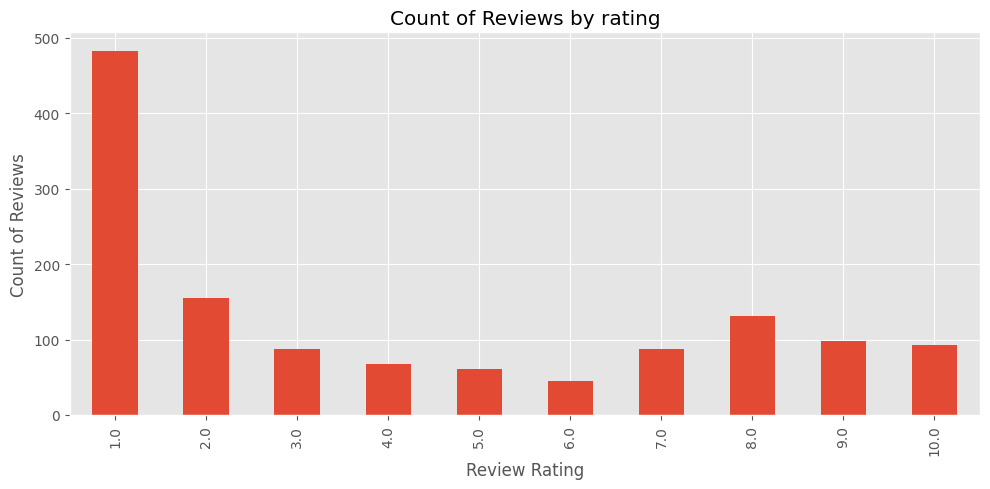

In [7]:
ax = df['Rating'].value_counts() \
    .sort_index().plot(kind='bar',title='Count of Reviews by rating',
                        figsize=(10, 5))
ax.set_xlabel('Review Rating')
ax.set_ylabel('Count of Reviews')
plt.tight_layout()
plt.show()

- **Rating Distribution**: The plot indicates that the most common review rating is 1.0, followed by 2.0 and 8.0. Ratings between 3.0 and 7.0 have relatively lower counts.

- **Skewness**: The distribution is skewed to the right, meaning there are more reviews with lower ratings compared to higher ratings.

- No significant outliers are observed in this graph.

> The graph suggests that a majority of reviews tend to be either very low or very high, with fewer reviews falling in the middle range. This could indicate that users are more likely to give extreme ratings, either positive or negative, rather than neutral ratings.

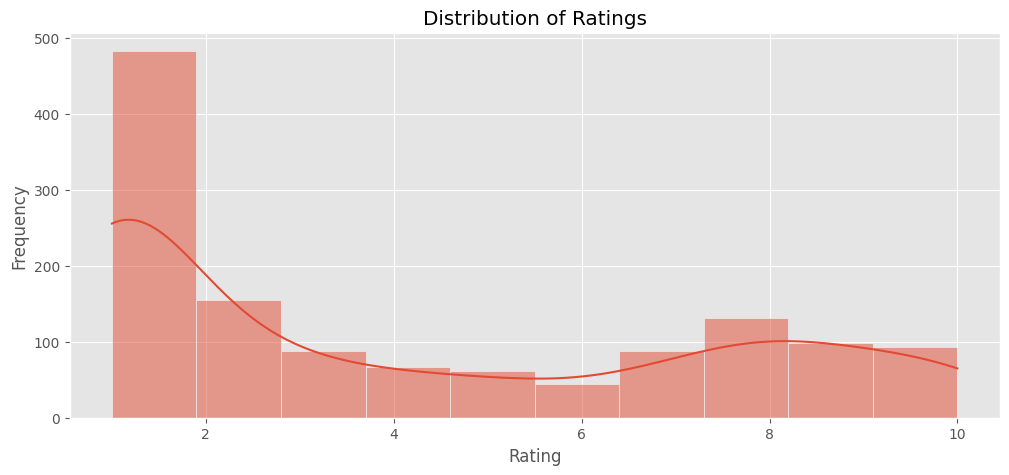

In [7]:
plt.figure(figsize=(12, 5))
sns.histplot(df['Rating'], bins=10, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

This graph shows a bimodal like distribution with peaks at 1.0 and 8.0. This might indicate polarizing customer experiences, where a large number of customers are either highly dissatisfied or quite satisfied.

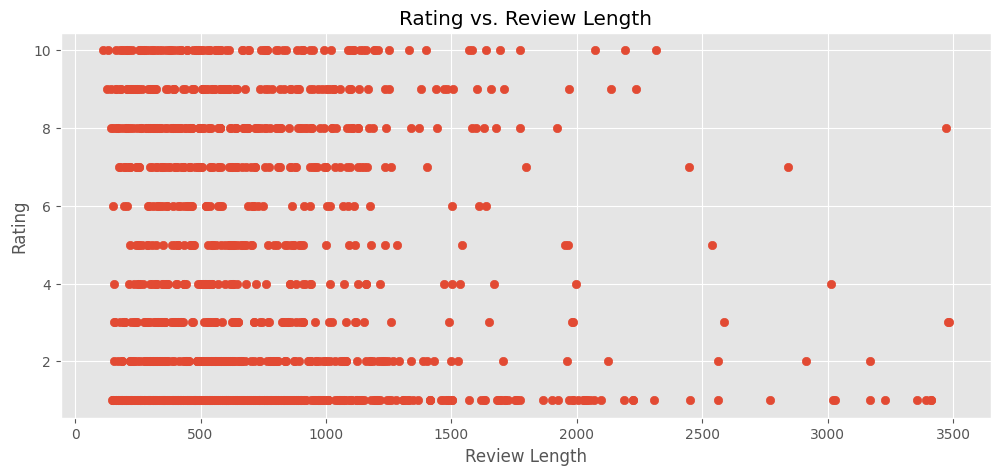

In [8]:
# Scatter Plot of Rating vs. Review Length
# Can be used to check if there's a relationship between 
# the length of a review and the given rating.

review_length = df['Reviews'].apply(len)
plt.figure(figsize=(12, 5))
plt.scatter(review_length, df['Rating'])
plt.xlabel('Review Length')
plt.ylabel('Rating')
plt.title('Rating vs. Review Length')
plt.show()

- **High Concentration of Short Reviews**: Most reviews, especially for low ratings (1 and 2), are relatively short, concentrated within the first 500-600 characters. This suggests that dissatisfied customers may tend to leave brief reviews expressing their frustration or dissatisfaction.

- **Longer Reviews Across All Ratings:** Very long reviews (1000+ characters) exist across the entire rating spectrum, meaning both highly satisfied and highly dissatisfied customers sometimes leave elaborate comments.

- **No strong correlation**: There doesn't appear to be a clear linear relationship between review length and rating. The data points are scattered across the graph, indicating that longer reviews don't necessarily lead to higher or lower ratings.

- **Clustering**: We can see some clustering of data points around certain rating values.

- We can also observe some outliers.

> The graph suggests that there is no strong correlation between review length and rating. Thus review length alone does not directly predict a customer’s rating

```python
# word cloud
from wordcloud import WordCloud


text = " ".join(review for review in df.Reviews)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud of Reviews')
plt.show()
```
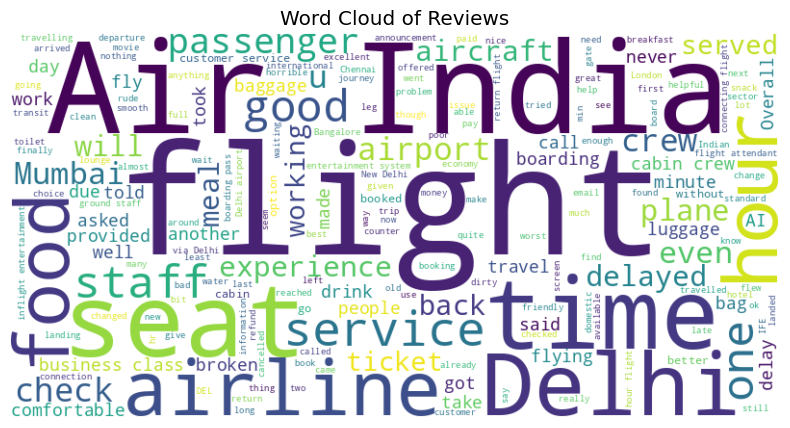

## Basic Text Preprocessing and NLTK tasks

In [27]:
# let us take one random example and work on it
# and then scale up
example = df['Reviews'][100]
example

'Very disappointed with the service. Every time I have travelled with this airline it has never been on time. Always delayed. Ground staff not very helpful.'

In [28]:
import nltk

In [60]:
# download necessary NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kanna\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kanna\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\kanna\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\kanna\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kanna\AppData\Roaming\nltk_data...


True

In [6]:
# tokenizing
tokens = nltk.word_tokenize(example)
tokens[:10]

['Very',
 'disappointed',
 'with',
 'the',
 'service',
 '.',
 'Every',
 'time',
 'I',
 'have']

In [7]:
# POS tagging
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('Very', 'RB'),
 ('disappointed', 'JJ'),
 ('with', 'IN'),
 ('the', 'DT'),
 ('service', 'NN'),
 ('.', '.'),
 ('Every', 'JJ'),
 ('time', 'NN'),
 ('I', 'PRP'),
 ('have', 'VBP')]

In [8]:
# named entity recognition
entities = nltk.ne_chunk(tagged)
entities.pprint()

(S
  Very/RB
  disappointed/JJ
  with/IN
  the/DT
  service/NN
  ./.
  Every/JJ
  time/NN
  I/PRP
  have/VBP
  travelled/VBN
  with/IN
  this/DT
  airline/NN
  it/PRP
  has/VBZ
  never/RB
  been/VBN
  on/IN
  time/NN
  ./.
  Always/NNS
  delayed/VBN
  ./.
  (PERSON Ground/NNP)
  staff/NN
  not/RB
  very/RB
  helpful/JJ
  ./.)


## Sentiment Analysis

### 1. Using TextBlob

- TextBlob is a simple library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more.

- `TextBlob` feature allows us to determine whether the input textual data has a positive, negative, or neutral tone.

- The sentiment function in TextBlob returns a sentiment tuple of the form (polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [29]:
from textblob import TextBlob

In [50]:
# let us try this on our example
sentiment = TextBlob(example)
sentiment.sentiment[0]

-0.5375000000000001

- For each method we try; lets add a new column to the dataframe, `Sentiment_Method_Used` which will contain the method output.

In [30]:
def textblob_method(text):
    return TextBlob(text).sentiment[0]

df['Sentiment_TextBlob'] = df['Reviews'].apply(textblob_method)

In [31]:
df.head()

,Reviews,Rating,Id,Sentiment_TextBlob
0,Flight was okay to travel as we don't have man...,4.0,1,0.288889
1,"After avoiding Air India for years, I was forc...",5.0,2,-0.070449
2,Horrible experience with customer care and sta...,4.0,3,-0.400000
3,I had decided to use my miles to redeem the fl...,2.0,4,0.368268
4,The Ticketing staff at Delhi Terminal 3 is wor...,9.0,5,-0.300000


Let us plot the distribution of the sentiment polarity scores.

```python
plt.figure(figsize=(12, 5))
sns.histplot(df['Sentiment_TextBlob'], bins=30, kde=True)
plt.title('Distribution of Sentiment Polarity Scores')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Count')
plt.show()
```

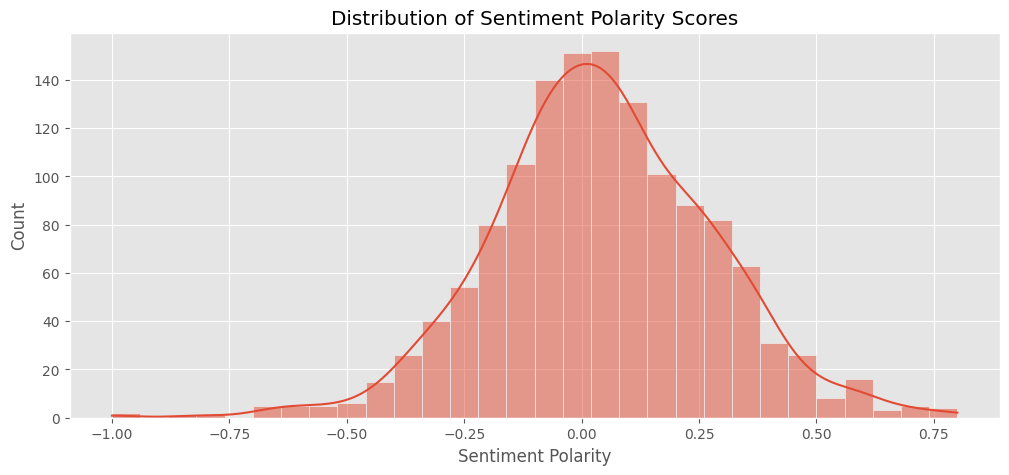

- **Normality**: The distribution appears to be approximately normal, with a bell-shaped curve.

- **Skewness**: There seems to be a slight positive skew, meaning that the tail on the right side of the distribution is slightly longer than the tail on the left. This indicates that there are a few more positive sentiment scores compared to negative ones.

- **Kurtosis**: The distribution appears to be slightly `leptokurtic`, meaning it has heavier tails than a normal distribution. This suggests that there are a few more extreme sentiment scores.

```python
df['Sentiment_TextBlob'].describe()
```

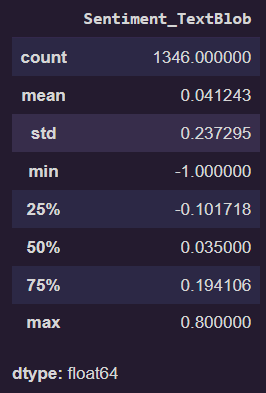

- The mean sentiment polarity is 0.041243, which indicates a slightly positive overall sentiment.

- The standard deviation is 0.237295, suggesting a moderate spread of sentiment scores. This means that there is a reasonable amount of variation in the sentiment expressed in the reviews.

- The minimum and maximum values are -1 and 0.8, respectively, confirming that the sentiment scores range from highly negative to highly positive.

>  This suggests that the airline's performance is not consistently positive and that there are areas where improvements can be made.

### Note

When we plotted ratings, we got the opposite of what we got here. The ratings indicated a high concentration of low ratings. However, the sentiment analysis shows a slightly positive overall sentiment. Either there is something wrong with `textblob` or somethings wrong with the ratings.


### 2. VADER (Valence Aware Dictionary and sEntiment Reasoner)

- VADER is a model used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion.

- It is a `bag of words` approach.
    -  Stop words are removed and each word is scored based on its sentiment and all these scores are combined to a total score.

In [32]:
# just a fancy progress tracker
from tqdm.notebook import tqdm

In [33]:
# VADER imports
from nltk.sentiment import SentimentIntensityAnalyzer

In [34]:
# instantiate the class
vader = SentimentIntensityAnalyzer()

In [71]:
# some examples
print(f"I am very happy: {vader.polarity_scores('I am very happy')}")
print(f"I am very happy: {vader.polarity_scores('I am very hapy')}")
print(f"I am very happy: {vader.polarity_scores('Awful experience')}")

I am very happy: {'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}
I am very happy: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
I am very happy: {'neg': 0.75, 'neu': 0.25, 'pos': 0.0, 'compound': -0.4588}


- Spelling mistakes can affect the score.

-  The `compound score` is the total score normalized between -1 and 1.

In [14]:
vader_example = vader.polarity_scores(example)
vader_example

{'neg': 0.263, 'neu': 0.737, 'pos': 0.0, 'compound': -0.7809}

In [35]:
vader_res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Reviews']
    myId = i
    vader_res[myId] = vader.polarity_scores(text)

  0%|          | 0/1346 [00:00<?, ?it/s]

In [36]:
vader_df = pd.DataFrame(vader_res).T
vader_df.head()

,neg,neu,pos,compound
0,0.069,0.801,0.131,0.5267
1,0.079,0.819,0.102,0.9374
2,0.261,0.617,0.122,-0.8287
3,0.017,0.821,0.162,0.9413
4,0.119,0.824,0.057,-0.8032


In [50]:
vader_df.rename(columns={ 
    'neg': 'vader_neg',
    'neu': 'vader_neu',
    'pos': 'vader_pos',
    'compound': 'vader_compound'
}, inplace=True)


vader_df.reset_index(inplace=True)

In [51]:
vader_df.rename(columns={'index': 'Id'}, inplace=True)

In [53]:
vader_df['Id'] += 1

In [54]:
vader_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound
0,1,0.069,0.801,0.131,0.5267
1,2,0.079,0.819,0.102,0.9374
2,3,0.261,0.617,0.122,-0.8287
3,4,0.017,0.821,0.162,0.9413
4,5,0.119,0.824,0.057,-0.8032


In [55]:
df.head()

,Reviews,Rating,Id,Sentiment_TextBlob
0,Flight was okay to travel as we don't have man...,4.0,1,0.288889
1,"After avoiding Air India for years, I was forc...",5.0,2,-0.070449
2,Horrible experience with customer care and sta...,4.0,3,-0.400000
3,I had decided to use my miles to redeem the fl...,2.0,4,0.368268
4,The Ticketing staff at Delhi Terminal 3 is wor...,9.0,5,-0.300000


In [56]:
df = df.merge(vader_df, how='left')

In [57]:
df.head()

,Reviews,Rating,Id,Sentiment_TextBlob,vader_neg,vader_neu,vader_pos,vader_compound
0,Flight was okay to travel as we don't have man...,4.0,1,0.288889,0.069,0.801,0.131,0.5267
1,"After avoiding Air India for years, I was forc...",5.0,2,-0.070449,0.079,0.819,0.102,0.9374
2,Horrible experience with customer care and sta...,4.0,3,-0.400000,0.261,0.617,0.122,-0.8287
3,I had decided to use my miles to redeem the fl...,2.0,4,0.368268,0.017,0.821,0.162,0.9413
4,The Ticketing staff at Delhi Terminal 3 is wor...,9.0,5,-0.300000,0.119,0.824,0.057,-0.8032


Plot VADER results

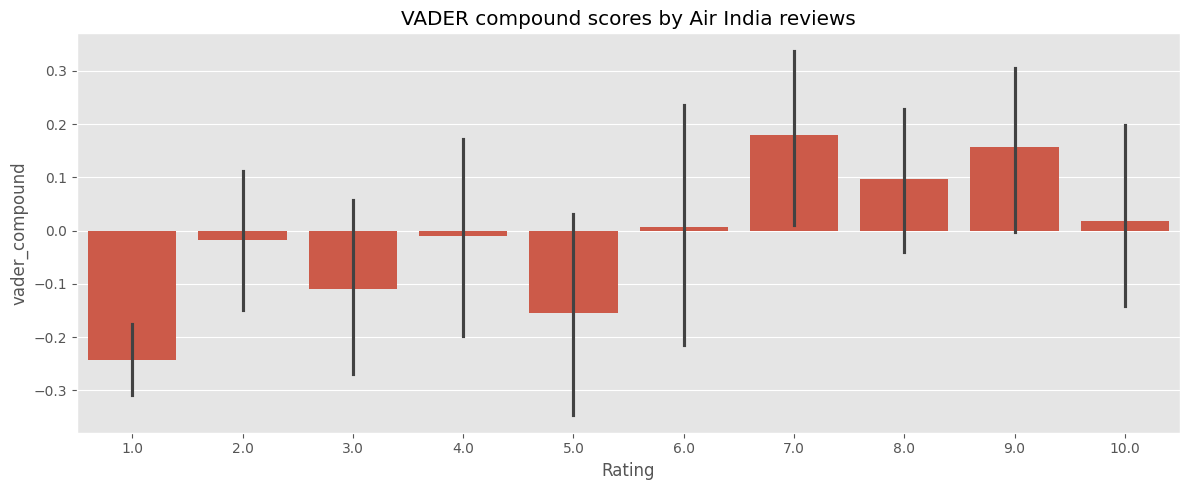

In [61]:
plt.figure(figsize=(12, 5))
ax = sns.barplot(data=df, x='Rating', y='vader_compound')
ax.set_title('VADER compound scores by Air India reviews')
plt.tight_layout()
plt.show()

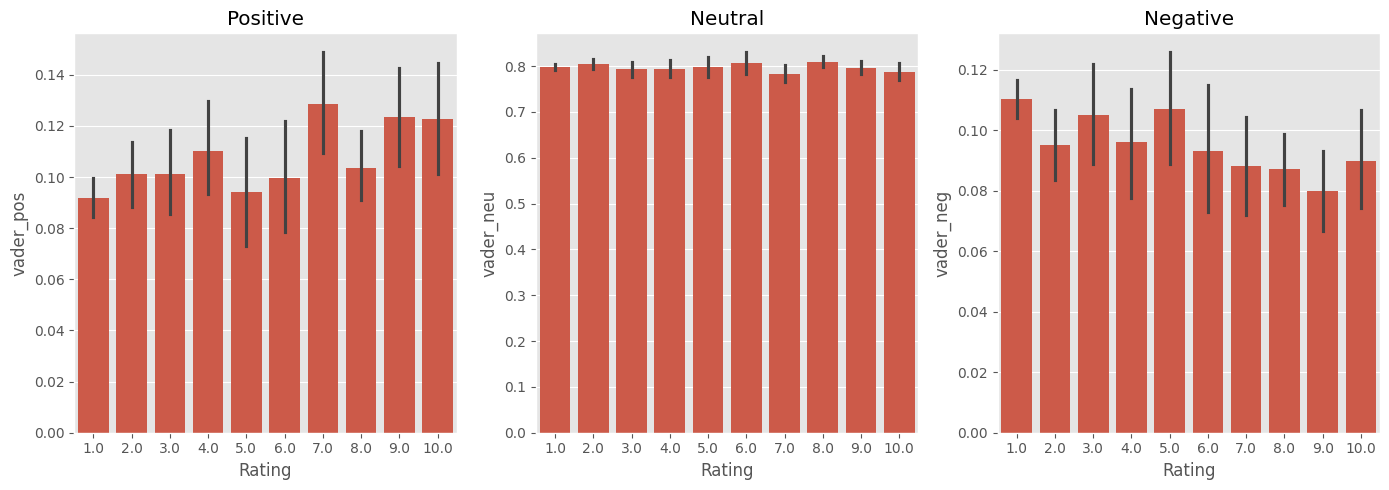

In [63]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
sns.barplot(data=df, x='Rating', y='vader_pos', ax=axs[0])
sns.barplot(data=df, x='Rating', y='vader_neu', ax=axs[1])
sns.barplot(data=df, x='Rating', y='vader_neg', ax=axs[2])

axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')

plt.tight_layout()
plt.show()

Like we did for TextBlob, we can plot the distribution of the sentiment scores obtained using VADER.

```python
plt.figure(figsize=(12, 5))
sns.histplot(df['vader_compound'], bins=30, kde=True)
plt.title('Distribution of Sentiment Polarity Scores')
plt.xlabel('Sentiment Polarity (VADER)')
plt.ylabel('Count')
plt.show()
```

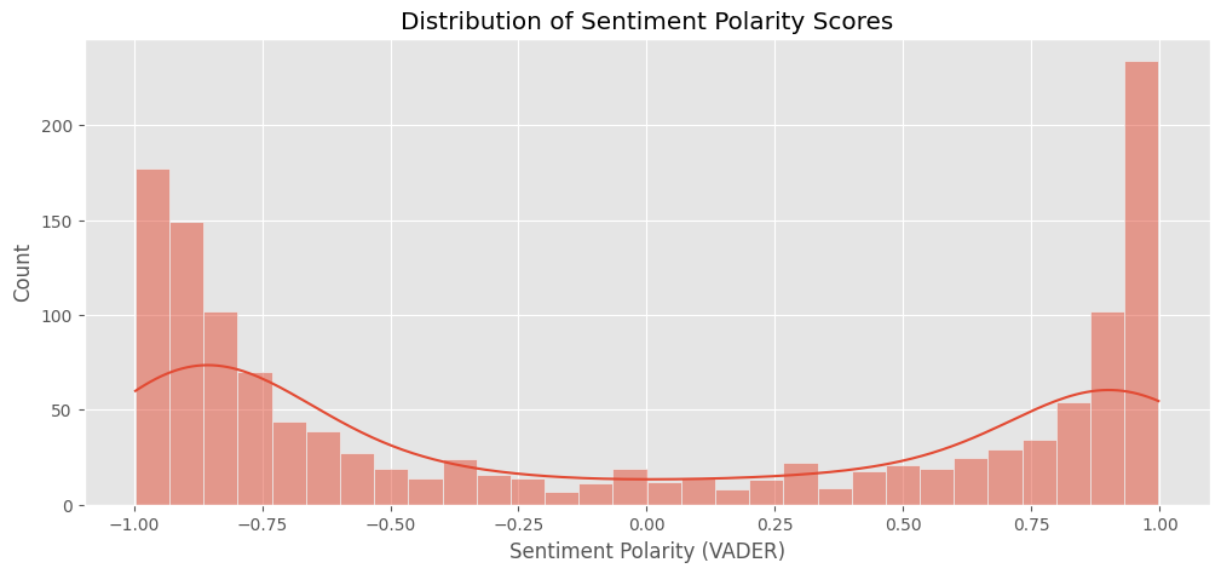

- This clearly appears to be a bimodal distribution.

- While the distribution is slightly skewed to the right, the presence of two distinct peaks suggests that the overall sentiment is not entirely positive. There is a significant portion of reviews with negative sentiment.

### 3. Using RoBERTa Pretrained Model

- We will use the `transformers` library to use the pretrained `roberta` model for sentiment analysis.

- `roberta` is a transformer model that is a version of BERT model. It is trained on more data and for more time than BERT. Basically it uses something called transformer architecture to understand the context of the words in a sentence.

- We are using a flavor of `roberta` which is fine tuned for sentiment analysis.

- More on transformers can be found [here](https://huggingface.co/transformers/)

- More on Roberta can be found [here](https://huggingface.co/transformers/model_doc/roberta.html)

- From here own, we will write GPU accelerated code; If your device doesn't have a GPU, run the code below in any hosted environment that has GPU support (Google Colab, Kaggle, etc.) or any paid cloud service of your choice.

In [72]:
import torch
from scipy.special import softmax
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

In [73]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [74]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)

In [76]:
# run roberta for example text
enc_text = tokenizer(example, return_tensors='pt', truncation=True, padding=True).to(device)

# Get model predictions
with torch.no_grad():
    output = model(**enc_text)
    
# Compute softmax to get probabilities
scores = output.logits[0].cpu().numpy()
scores = softmax(scores)

# Map scores to a dictionary
scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}

In [77]:
scores_dict

{'roberta_neg': 0.9704047,
 'roberta_neu': 0.026153032,
 'roberta_pos': 0.0034422814}

In [33]:
vader_example

{'neg': 0.263, 'neu': 0.737, 'pos': 0.0, 'compound': -0.7809}

In [78]:
example

'Very disappointed with the service. Every time I have travelled with this airline it has never been on time. Always delayed. Ground staff not very helpful.'

In [79]:
# Function to get polarity scores using RoBERTa GPU
def roberta_polarity_score(text):
    # Tokenize input text
    enc_text = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(device)
    
    # Get model predictions
    with torch.no_grad():
        output = model(**enc_text)
    
    # Compute softmax to get probabilities
    scores = output.logits[0].cpu().numpy()
    scores = softmax(scores)
    
    # Map scores to a dictionary
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [ ]:
# Initialize result dictionary
roberta_res = {}

# Iterate over dataframe rows
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Reviews']
        roberta_res[i] = roberta_polarity_score(text)
    except Exception as e:
        print(f"Error processing id {i}: {e}")

# Convert results to a dataframe for further analysis
results_df = pd.DataFrame.from_dict(roberta_res, orient='index')

In [85]:
results_df.head()

,Id,roberta_neg,roberta_neu,roberta_pos
0,1,0.078149,0.282131,0.639720
1,3,0.967911,0.028673,0.003416
2,4,0.004896,0.092259,0.902846
3,5,0.845114,0.141470,0.013417
4,6,0.982851,0.015231,0.001918


In [82]:
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df['Id'] += 1
df = df.merge(results_df, how='left')

In [86]:
df.head()

,Reviews,Rating,Id,Sentiment_TextBlob,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos
0,Flight was okay to travel as we don't have man...,4.0,1,0.288889,0.069,0.801,0.131,0.5267,0.078149,0.282131,0.639720
1,"After avoiding Air India for years, I was forc...",5.0,2,-0.070449,0.079,0.819,0.102,0.9374,NaN,NaN,NaN
2,Horrible experience with customer care and sta...,4.0,3,-0.400000,0.261,0.617,0.122,-0.8287,0.967911,0.028673,0.003416
3,I had decided to use my miles to redeem the fl...,2.0,4,0.368268,0.017,0.821,0.162,0.9413,0.004896,0.092259,0.902846
4,The Ticketing staff at Delhi Terminal 3 is wor...,9.0,5,-0.300000,0.119,0.824,0.057,-0.8032,0.845114,0.141470,0.013417


In [87]:
df.isna().sum()

Reviews                0
Rating                37
Id                     0
Sentiment_TextBlob     0
vader_neg              0
vader_neu              0
vader_pos              0
vader_compound         0
roberta_neg           23
roberta_neu           23
roberta_pos           23
dtype: int64

In [88]:
df.columns

Index(['Reviews', 'Rating', 'Id', 'Sentiment_TextBlob', 'vader_neg',
       'vader_neu', 'vader_pos', 'vader_compound', 'roberta_neg',
       'roberta_neu', 'roberta_pos'],
      dtype='object')

Also let us try to create a ROBERTA compound score.

```python
def calculate_compound_score(row):
    roberta_neg = row['roberta_neg']
    roberta_pos = row['roberta_pos']
    
    # Compound score as the difference between positive and negative probabilities
    compound_score = roberta_pos - roberta_neg
    return compound_score

results_df['roberta_compound_score'] = results_df.apply(calculate_compound_score, axis=1)
```

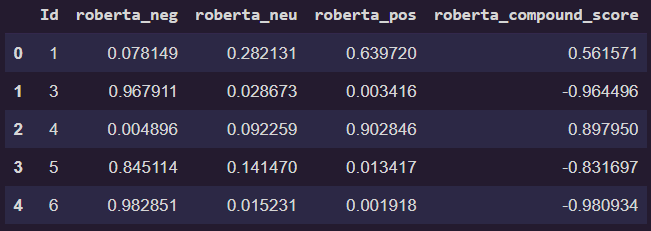

Now we can plot the distribution of the sentiment scores obtained using RoBERTa.

```python
plt.figure(figsize=(12, 5))
sns.histplot(df['roberta_compound_score'], bins=30, kde=True)
plt.title('Distribution of Sentiment Polarity Scores')
plt.xlabel('Sentiment Polarity (ROBERTA)')
plt.ylabel('Count')
plt.show()
```

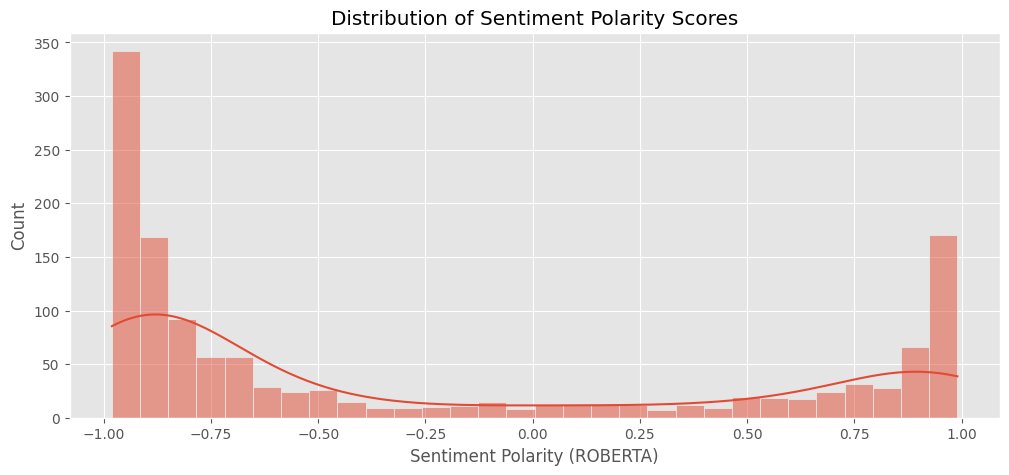

- Almost same as VADER.

### Review of different models performance

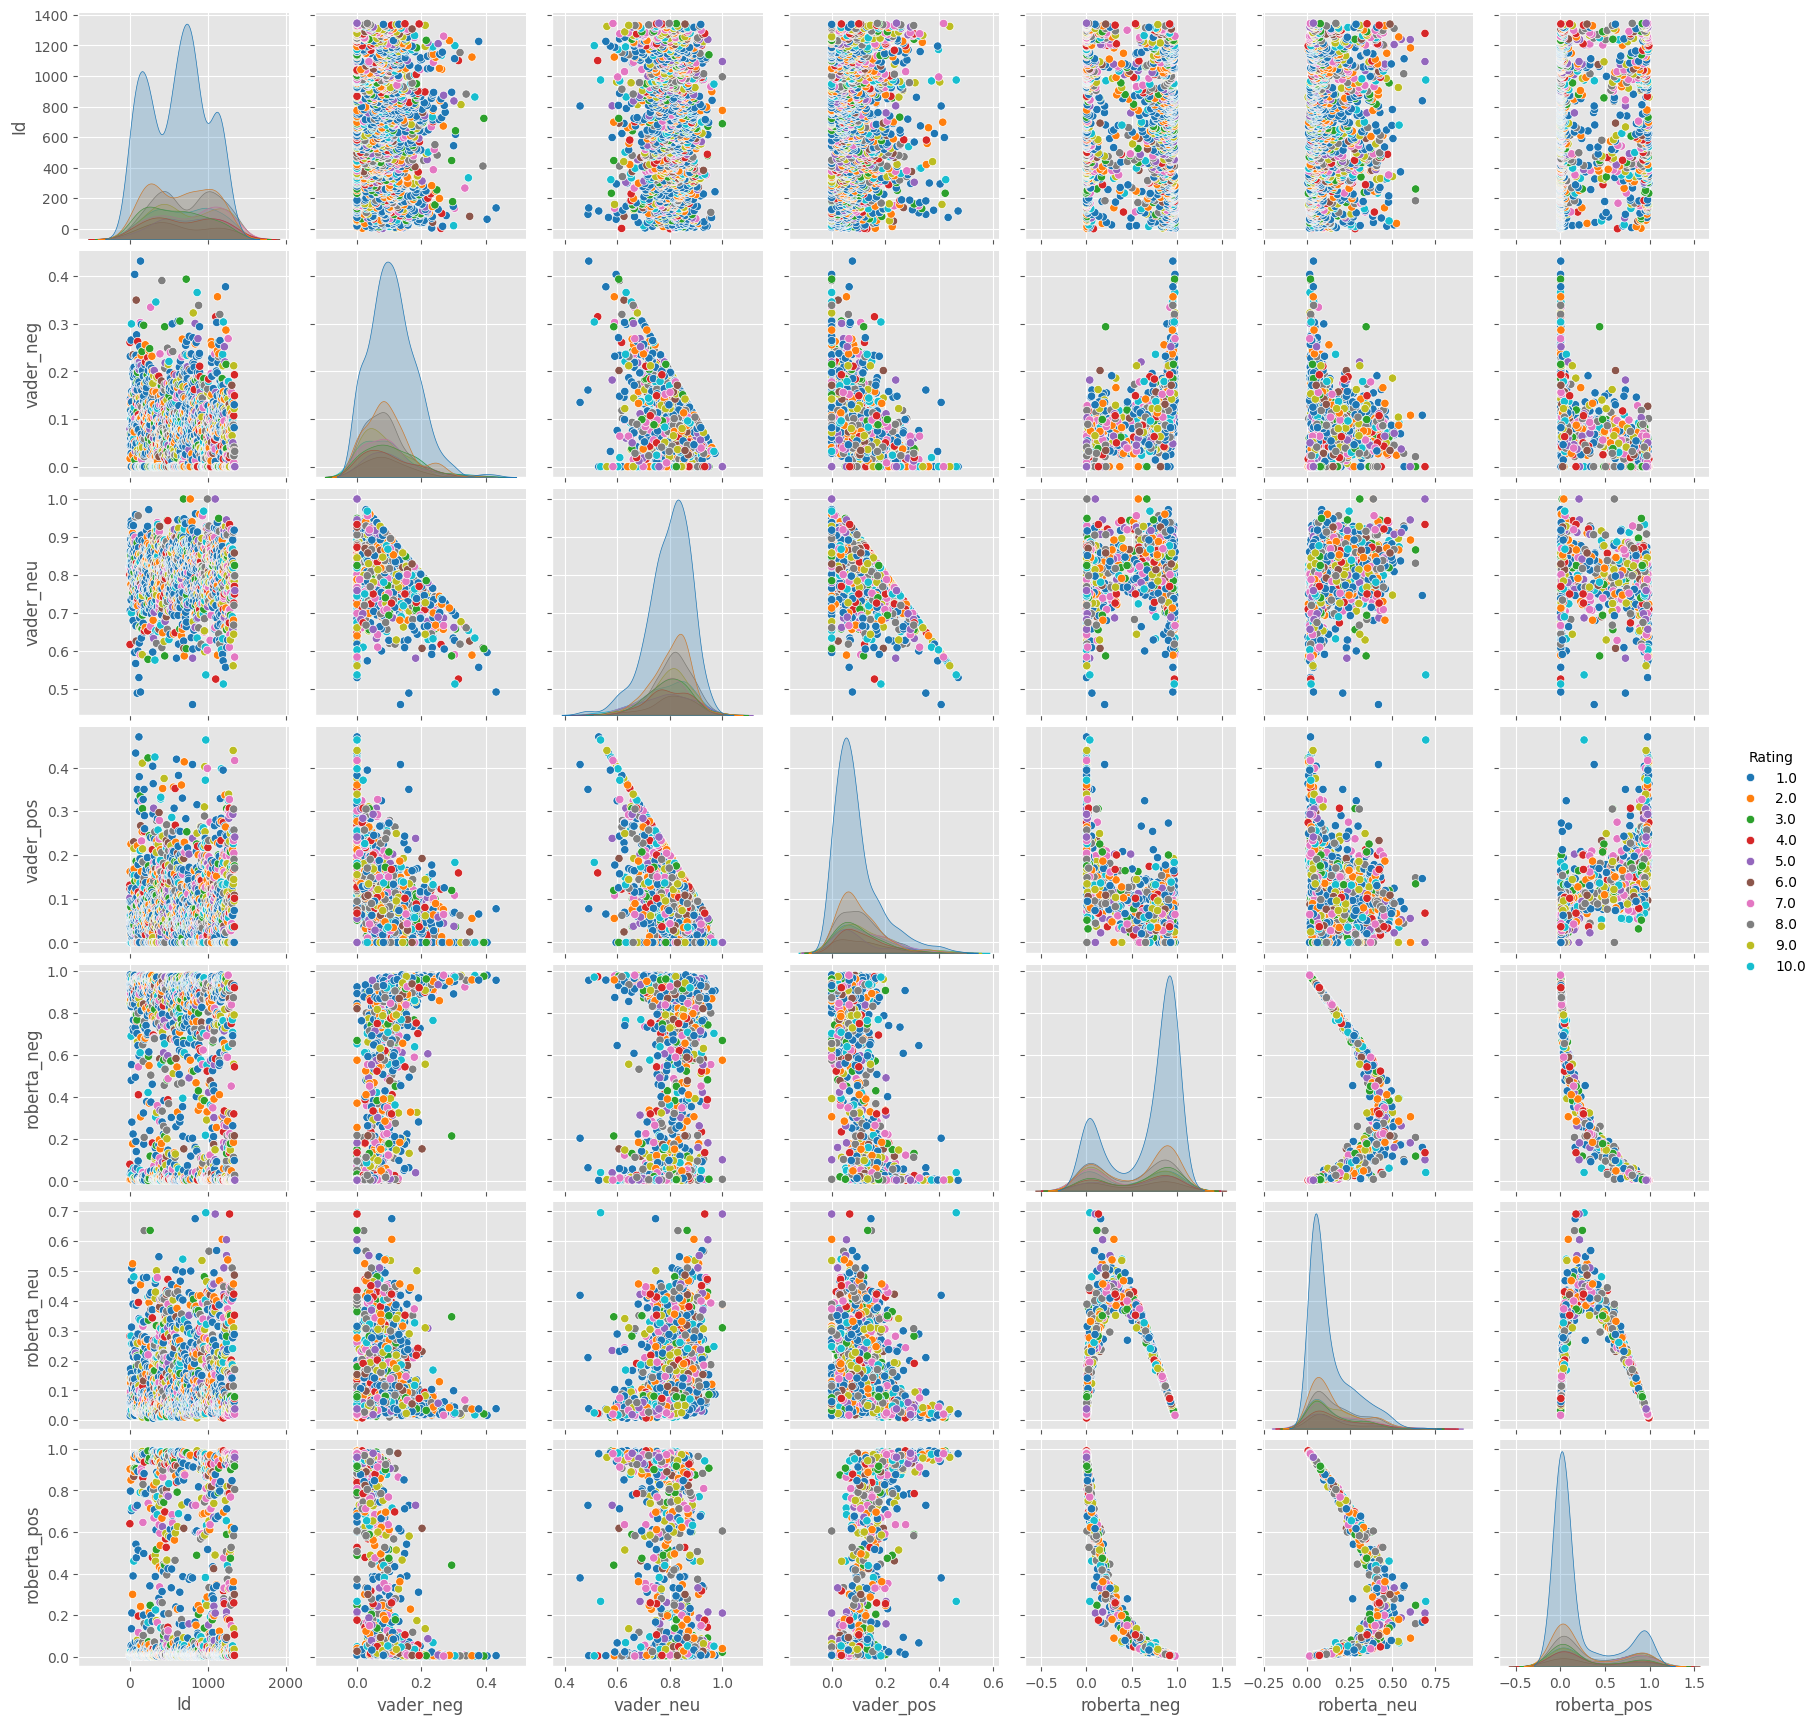

In [90]:
sns.pairplot(data=df, vars=['Id', 'vader_neg','vader_neu', 'vader_pos', 
                                    'roberta_neg', 'roberta_neu', 'roberta_pos'],
                                    hue='Rating', palette='tab10')
plt.show()

In [109]:
df.query('Rating == 1.0').sort_values('roberta_pos', ascending=False)

,Reviews,Rating,Id,Sentiment_TextBlob,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos
299,The flight was great! The staff were extremely...,1.0,300,0.586667,0.000,0.637,0.363,0.9876,0.001496,0.006668,0.991836
673,Chennai to Delhi. Excellent service by the air...,1.0,674,0.666667,0.000,0.670,0.330,0.9061,0.001322,0.010283,0.988396
623,New Delhi to Dubai and I had a great Flight. I...,1.0,624,0.518377,0.000,0.618,0.382,0.9438,0.001372,0.010270,0.988358
1162,"Delhi to Dubai, flight AI 995. It was a fabulo...",1.0,1163,0.354396,0.000,0.751,0.249,0.9847,0.001682,0.010185,0.988133
296,Had a wonderful experience flying with Air Ind...,1.0,297,0.407500,0.000,0.706,0.294,0.9886,0.001700,0.011148,0.987153
...,...,...,...,...,...,...,...,...,...,...,...
725,Our flight route was from Washington DC IAD to...,1.0,726,0.030288,0.077,0.888,0.035,-0.9722,NaN,NaN,NaN
749,I had booked a business class ticket using mil...,1.0,750,-0.008559,0.107,0.846,0.047,-0.9840,NaN,NaN,NaN
772,I had my first experience with Air India recen...,1.0,773,-0.028611,0.128,0.795,0.077,-0.9792,NaN,NaN,NaN
1017,Mumbai to Hong Kong via Delhi. I had an absolu...,1.0,1018,0.004188,0.074,0.842,0.084,0.8043,NaN,NaN,NaN


In [98]:
df.query('Rating == 1.0').sort_values('roberta_pos', ascending=False)['Reviews'].values[0]

'The flight was great! The staff were extremely kind and helpful, the entertainment system were very easy-to-use and the food was really good as well. The inside of the flight was very nice (All Air India flights are being renovated to match or be even better than the likes of Emirates and Qatar Airways). This was one of the best flights I have been on, better than British Airways, Etihad and tied to Lufthansa.'

- This indicates some serious issue with our data, even for positive reviews, people have given negative ratings. This is also the primary reason for the low mean rating and 75% of the ratings being below 3.0.

In [103]:
df.query('Rating == 10.0').sort_values('roberta_neg', ascending=False)

,Reviews,Rating,Id,Sentiment_TextBlob,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos
862,This airline is by far the worst I have ever f...,10.0,863,-0.386667,0.366,0.634,0.000,-0.9325,0.979311,0.018239,0.002450
1198,Pathetic airline. Ruining the image of the cou...,10.0,1199,-0.366667,0.304,0.513,0.183,-0.5487,0.971798,0.024673,0.003529
281,There was a 2hr baggage clearance at Mumbai co...,10.0,282,-0.317857,0.195,0.771,0.034,-0.8936,0.970612,0.026643,0.002744
731,Overall the customer service is extremely poor...,10.0,732,-0.330357,0.234,0.729,0.037,-0.9819,0.969938,0.026683,0.003379
950,Bangkok to Mumbai. We were travelling along wi...,10.0,951,-1.000000,0.167,0.766,0.067,-0.6369,0.968553,0.027840,0.003607
...,...,...,...,...,...,...,...,...,...,...,...
394,Delhi to Lucknow with Air India - first time o...,10.0,395,0.316667,0.000,0.812,0.188,0.9371,0.001604,0.010241,0.988155
320,London to Delhi. An excellent service and expe...,10.0,321,0.416667,0.000,0.827,0.173,0.7845,0.001579,0.012348,0.986073
942,I travelled on Air India from London(LHR) to C...,10.0,943,0.333376,0.000,0.782,0.218,0.9933,0.001463,0.020103,0.978434
537,We had flown on 27th September 2018 on Air Ind...,10.0,538,0.638528,0.000,0.714,0.286,0.9516,0.001247,0.012259,0.986494


In [104]:
df.query('Rating == 10.0').sort_values('roberta_neg', ascending=False)['Reviews'].values[0]

'This airline is by far the worst I have ever flown with. No screens working, only one toilet from 4 working, no overhead lighting working. Awful food and the poorest drinks selection ever.'

- Again the same issue, for extreme negative people have given 10 out of 10 ratings.

In [105]:
# data points with roberta_pos or roberta_neu is greater than roberta_neg
# roberta model due to its limitation in context size again couldn't fit every data points
filtered_df = df[(df['roberta_pos'] > df['roberta_neg']) | (df['roberta_neu'] > df['roberta_neg'])]

In [108]:
print(f"Out of {len(df)} data points, {len(filtered_df)} were positive or neutral according to roberta model")

Out of 1346 data points, 494 were positive or neutral according to roberta model


### 4. Using Pipeline from transformers

In [110]:
from transformers import pipeline

p = pipeline("sentiment-analysis", device=device)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [116]:
print(f"The model we are going to use is: {p.model.name_or_path}")

The model we are going to use is: distilbert/distilbert-base-uncased-finetuned-sst-2-english


In [111]:
reviews = [
    "Flight was okay to travel as we don't have many options",
    "After avoiding Air India for years, I was forced to take a flight",
    "Horrible experience with customer care and staff",
    "I had decided to use my miles to redeem the flight",
    "The Ticketing staff at Delhi Terminal 3 is worst"
]

results = p(reviews)

# Print results
for review, result in zip(reviews, results):
    print(f"Review: {review}\nSentiment: {result['label']}, Score: {result['score']}\n")

Review: Flight was okay to travel as we don't have many options
Sentiment: POSITIVE, Score: 0.9974859952926636

Review: After avoiding Air India for years, I was forced to take a flight
Sentiment: NEGATIVE, Score: 0.9974199533462524

Review: Horrible experience with customer care and staff
Sentiment: NEGATIVE, Score: 0.99972003698349

Review: I had decided to use my miles to redeem the flight
Sentiment: POSITIVE, Score: 0.8220815658569336

Review: The Ticketing staff at Delhi Terminal 3 is worst
Sentiment: NEGATIVE, Score: 0.9997954964637756



In [114]:
example

'Very disappointed with the service. Every time I have travelled with this airline it has never been on time. Always delayed. Ground staff not very helpful.'

In [113]:
p(example)

[{'label': 'NEGATIVE', 'score': 0.9996229410171509}]

Lets use the pipeline from transformers library to get the sentiment of the reviews.

```python
from transformers import pipeline

p = pipeline("sentiment-analysis", device=device)

results = p(df.Reviews.tolist(), truncation=True, padding=True)
```

```python
results[:10]
```

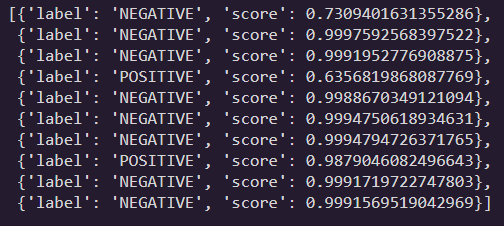

```python
df['distil_bert_sentiment_label'] = [result['label'] for result in results]
df['distil_bert_sentiment_score'] = [result['score'] for result in results]
```

```python
df.head(10)
```

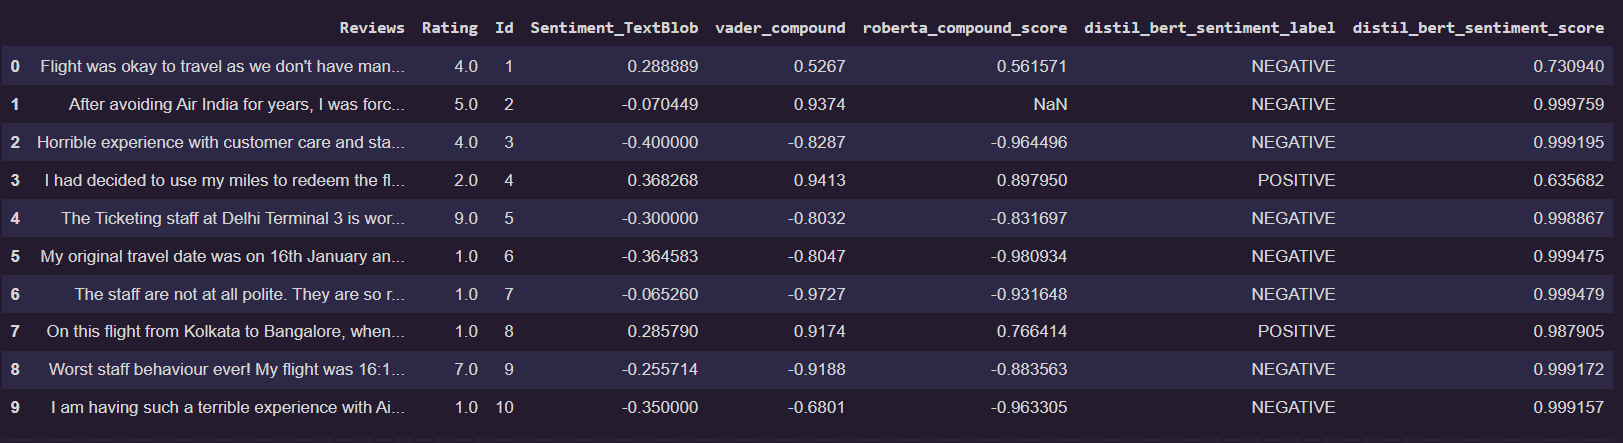

Now we can plot the distribution of the sentiment label obtained using DistilBERT.

```python
# Set the visual style
sns.set(style="whitegrid")

# Create a count plot for distil_bert_sentiment_label
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='distil_bert_sentiment_label', palette='viridis')

# Add title and labels
plt.title('Distribution of Distil BERT Sentiment Labels', fontsize=16)
plt.xlabel('Sentiment Label', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Show the plot
plt.show()
```

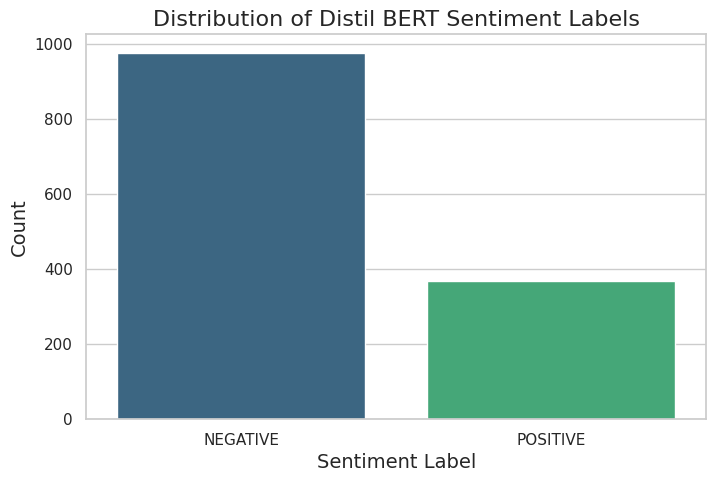

If we plot the sentiment scores; 

```python
plt.figure(figsize=(12, 5))
sns.histplot(df['distil_bert_sentiment_score'], bins=10, kde=True)
plt.title('Distribution of Sentiment Polarity Scores')
plt.xlabel('Sentiment Polarity (Distil Bert)')
plt.ylabel('Count')
plt.show()
```

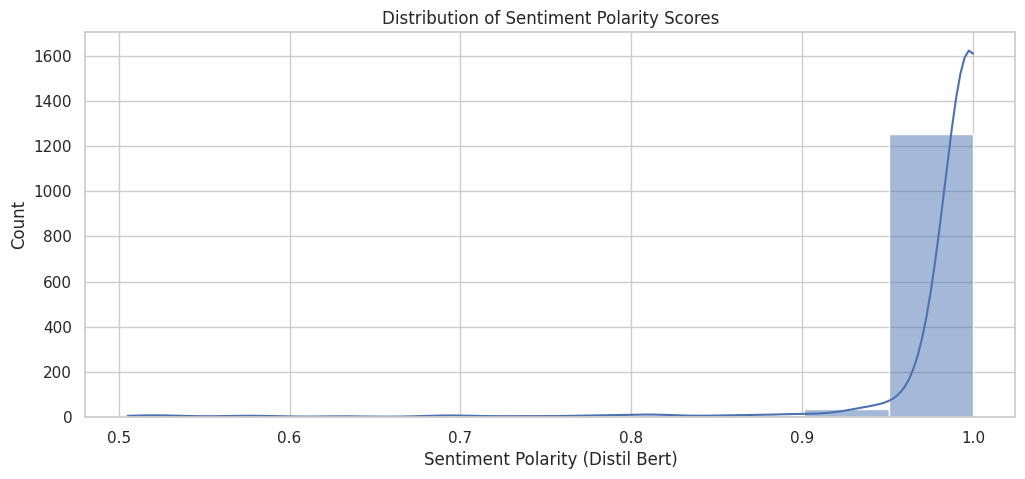

- By default the pipeline uses `distilbert-base-uncased-finetuned-sst-2-english` model and it give two outputs; `label` and `score`. The distribution of sentiment score is concentrated around 1.0, indicating the extreme nature of the sentiment expressed in the reviews (either very positive or very negative).

### The END